In [3]:
import tensorflow as tf
from tensorflow import keras
# import sklearn
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix

import sys,os
from importlib import reload
sys.path.append('..')

import cv2
# import skimage
from PIL import Image
import random
import math
from tensorflow.keras.models import Model, save_model, load_model
from pconv_layer import PConv2D

In [4]:
from tkinter import ttk, Tk, PhotoImage, RIDGE, Canvas, GROOVE

In [5]:
# Mask Extraction
def extract_mask(img, interval) :
    if(len(img.shape) == 2):
        h, w = img.shape
    else:
        x, h, w = img.shape
    # interval = 10
#     (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(img)
    
    maxVal = img[..., 0].max()
    maxVal = int(maxVal)
    mask = img.copy()
    count = 0
    for row in range(h):
          for col in range(w):
            mask[row,col] = 255 if (maxVal - interval < img[row,col] < maxVal + interval) else 0
            if mask[row,col] == 255: 
                  count+=1
#     cv2_imshow(mask)
    kernel = np.ones((2, 2), np.uint8)
    # mask3 = cv2.dilate(mask, kernel, iterations = 1)

    mask3 = cv2.dilate(mask, kernel, iterations = 1)
#     cv2_imshow(mask3)
    plt.imshow(mask3, cmap= 'gray')
    plt.show()
    return mask3


In [10]:
# Inpainting
def closest_pixel(mask, i, j, img):
    if(len(img.shape) == 2):
        h, w = img.shape
    else:
        x, h, w = img.shape
    pos = None
    distance = max(h,w)
    # rand = random.randint(0, randomax) 
    # down
    for x in range(i, h):
          if x-i < distance and mask[x,j] == 0:
            distance = x-i
            pos = (x ,j)
            break
    # print("down",distance, pos)
    # down
    for x in range(j, w):
          if x-j < distance and mask[i,x] == 0:
            distance = x-j
            pos = (i,x)
            break
    # print("down",distance, pos)
    # left
    for x in range(i, 0, -1):
          if i - x < distance and mask[x,j] == 0:
            distance = i - x
            pos = (x,j)
            break
    # print("down",distance, pos)
    # up
    for x in range(j, 0, -1):
          if j - x < distance and mask[i,x] == 0:
            distance = j - x
            pos = (i,x)
            break
    # print("down",distance, pos)
    return pos

def inpaint(img,mask):
    if(len(img.shape) == 2):
        h, w = img.shape
    else:
        x, h, w = img.shape
    count = 0
    img_r = img.copy()

    for row in range(h):
        for col in range(w):
              if mask[row,col] == 255 :
                count +=1
                (x,y) = closest_pixel(mask, row, col,img)
                # print(x,y)
                img_r[row,col] = img[x,y]

    print(count)

#     plt.imshow(img, cmap= 'gray')
#     plt.show()
#     plt.imshow(img_r,cmap= 'gray')
#     plt.show()
#     cv2.waitKey(0)

    # closing all open windows
#     cv2.destroyAllWindows()
    return img_r

In [11]:
def fix_usntrucured_defect(img, size_kernel):
    kernel = np.ones((size_kernel, size_kernel), np.float32)/25
    median = cv2.medianBlur(img,5)
    # median = cv2.GaussianBlur(img,(5,5),0)
    median = cv2.blur(img,(3,3))
    size = (3, 3)
    shape = cv2.MORPH_RECT
    kernel = cv2.getStructuringElement(shape, size)

    # Applies the minimum filter with kernel NxN
    imgResult = cv2.erode(img, kernel)
    # imgResult= cv2.blur(img,(5,5),0)
    # cv2_imshow(median)
    return imgResult

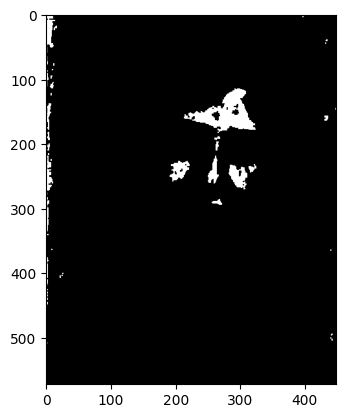

6702


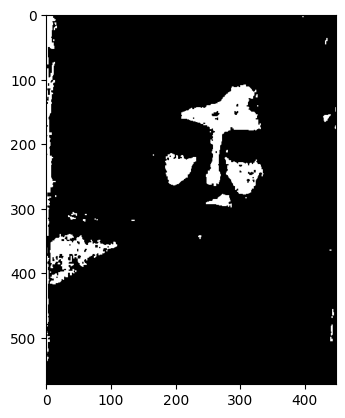

16270


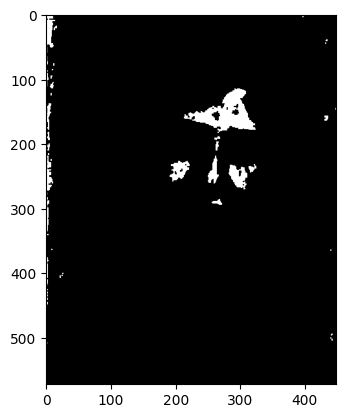

6702


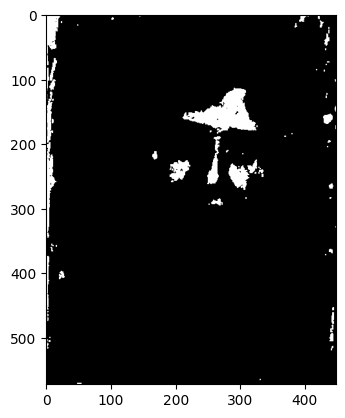

10473


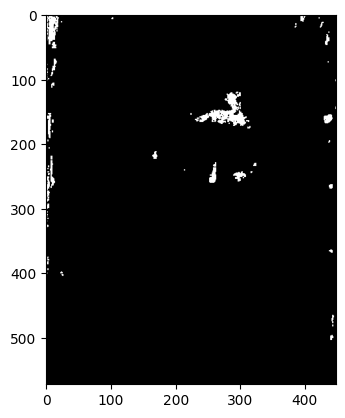

3968


In [ ]:
# UI
from tkinter import *
from tkinter import filedialog
import cv2
from PIL import ImageTk, Image
import numpy as np

class FrontEnd:
    def __init__(self, master):
        self.master = master
        self.menu_initialisation()
        
    def menu_initialisation(self):
        self.master.geometry('700x550')
        self.master.title('Old Photo Restoration')
        self.master.config(bg='white')

        self.frame_header = ttk.Frame(self.master)
        self.frame_header.pack()
        
#         self.logo = PhotoImage(file='logo1.png').subsample(2, 2)
#         print(self.logo)
#         ttk.Label(self.frame_header, image=self.logo).grid(
#             row=0, column=0, rowspan=2)

        row = 0
        Label(self.frame_header, text='Old Photo Restoration', fg='white', font='Arial 16 bold', width=50, height=2,bg='#009EFF').grid(row=row, column=2, columnspan=1)
        row += 1
#         ttk.Label(self.frame_header, text='An Image Editor Just For You!').grid(row=row, column=2, columnspan=1)
#         row += 1
        
        self.frame_menu = Frame(self.master)
        self.frame_menu.pack(pady=20)
        self.frame_menu.config(relief=RIDGE,bd=2, bg='#72FFFF', borderwidth=0)
        
        Button(
            self.frame_menu, text="Upload An Image", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15,command=self.upload_action).grid(
            row=row, column=0, columnspan=2, padx=5, pady=5, sticky='sw' )
        row += 1
#         photo = PhotoImage(file = r"C:\Users\awwad\OneDrive\Desktop\Crop.png")
        Button(
            self.frame_menu, text="Crop Image", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.crop_action).grid(
            row=row, column=0, columnspan=2, padx=5, pady=5, sticky='sw')
        row += 1

        Button(
            self.frame_menu, text="Enhance image", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.filter_action).grid(
            row=row, column=0, columnspan=2, padx=5, pady=5, sticky='sw')
        row += 1
        
        Button(
            self.frame_menu, text="Rotate", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.rotate_action).grid(
            row=row, column=0, columnspan=2, padx=5, pady=5, sticky='sw')
        row += 1

        Button(
            self.frame_menu, text="Flip", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.flip_action).grid(
            row=row, column=0, columnspan=2, padx=5, pady=5, sticky='sw')
        row += 1

        Button(
            self.frame_menu, text="Save As", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.save_action).grid(
            row=row, column=0, columnspan=2, padx=5, pady=5, sticky='sw')
        row += 1
        
        self.canvas = Canvas(self.frame_menu, bg='white', width=400, height=400, borderwidth=0)
        self.canvas.grid(row=0, column=3, rowspan=10)
        
        self.side_frame = Frame(self.frame_menu, bg='#72FFFF')
        self.side_frame.grid(row=0, column=4, rowspan=10)
        self.side_frame.config(relief=GROOVE)
        
        self.apply_and_cancel = Frame(self.master, bd=2, bg='#72FFFF')
        self.apply_and_cancel.pack()
        self.apply = Button(self.apply_and_cancel, text="Apply",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.apply_action).grid(
            row=0, column=0, columnspan=1, padx=5, pady=5, sticky='sw')

        Button(
            self.apply_and_cancel, text="Cancel",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.cancel_action).grid(
                row=0, column=1, columnspan=1,padx=5, pady=5, sticky='sw')

        Button(
            self.apply_and_cancel, text="Revert All Changes",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.revert_action).grid(
                row=0, column=2, columnspan=1,padx=5, pady=5, sticky='sw')
        

        
    def upload_action(self):
        self.canvas.delete("all")
        self.filename = filedialog.askopenfilename()
        self.original_image = cv2.imread(self.filename)

        self.edited_image = cv2.imread(self.filename)
        self.filtered_image = cv2.imread(self.filename)
        self.display_image(self.edited_image)

    def crop_action(self):
        self.rectangle_id = 0
        # self.ratio = 0
        self.crop_start_x = 0
        self.crop_start_y = 0
        self.crop_end_x = 0
        self.crop_end_y = 0
        self.canvas.bind("<ButtonPress>", self.start_crop)
        self.canvas.bind("<B1-Motion>", self.crop)
        self.canvas.bind("<ButtonRelease>", self.end_crop)

    def start_crop(self, event):
        self.crop_start_x = event.x
        self.crop_start_y = event.y

    def crop(self, event):
        if self.rectangle_id:
            self.canvas.delete(self.rectangle_id)

        self.crop_end_x = event.x
        self.crop_end_y = event.y

        self.rectangle_id = self.canvas.create_rectangle(self.crop_start_x, self.crop_start_y,
                                                         self.crop_end_x, self.crop_end_y, width=1)

    def end_crop(self, event):
        if self.crop_start_x <= self.crop_end_x and self.crop_start_y <= self.crop_end_y:
            start_x = int(self.crop_start_x * self.ratio)
            start_y = int(self.crop_start_y * self.ratio)
            end_x = int(self.crop_end_x * self.ratio)
            end_y = int(self.crop_end_y * self.ratio)
        elif self.crop_start_x > self.crop_end_x and self.crop_start_y <= self.crop_end_y:
            start_x = int(self.crop_end_x * self.ratio)
            start_y = int(self.crop_start_y * self.ratio)
            end_x = int(self.crop_start_x * self.ratio)
            end_y = int(self.crop_end_y * self.ratio)
        elif self.crop_start_x <= self.crop_end_x and self.crop_start_y > self.crop_end_y:
            start_x = int(self.crop_start_x * self.ratio)
            start_y = int(self.crop_end_y * self.ratio)
            end_x = int(self.crop_end_x * self.ratio)
            end_y = int(self.crop_start_y * self.ratio)
        else:
            start_x = int(self.crop_end_x * self.ratio)
            start_y = int(self.crop_end_y * self.ratio)
            end_x = int(self.crop_start_x * self.ratio)
            end_y = int(self.crop_start_y * self.ratio)

        x = slice(start_x, end_x, 1)
        y = slice(start_y, end_y, 1)

        self.filtered_image = self.edited_image[y, x]
        self.display_image(self.filtered_image)

    def text_action(self):
        self.rectangle_id = 0
        # self.ratio = 0
        self.crop_start_x = 0
        self.crop_start_y = 0
        self.crop_end_x = 0
        self.crop_end_y = 0
        self.canvas.bind("<ButtonPress>", self.start_crop)
        self.canvas.bind("<B1-Motion>", self.crop)
        self.canvas.bind("<ButtonRelease>", self.end_text_crop)

    def end_text_crop(self, event):
        if self.crop_start_x <= self.crop_end_x and self.crop_start_y <= self.crop_end_y:
            start_x = int(self.crop_start_x * self.ratio)
            start_y = int(self.crop_start_y * self.ratio)
            end_x = int(self.crop_end_x * self.ratio)
            end_y = int(self.crop_end_y * self.ratio)
        elif self.crop_start_x > self.crop_end_x and self.crop_start_y <= self.crop_end_y:
            start_x = int(self.crop_end_x * self.ratio)
            start_y = int(self.crop_start_y * self.ratio)
            end_x = int(self.crop_start_x * self.ratio)
            end_y = int(self.crop_end_y * self.ratio)
        elif self.crop_start_x <= self.crop_end_x and self.crop_start_y > self.crop_end_y:
            start_x = int(self.crop_start_x * self.ratio)
            start_y = int(self.crop_end_y * self.ratio)
            end_x = int(self.crop_end_x * self.ratio)
            end_y = int(self.crop_start_y * self.ratio)
        else:
            start_x = int(self.crop_end_x * self.ratio)
            start_y = int(self.crop_end_y * self.ratio)
            end_x = int(self.crop_start_x * self.ratio)
            end_y = int(self.crop_start_y * self.ratio)

        if self.text_on_image.get():
            self.text_extracted = self.text_on_image.get()
        start_font = start_x, start_y
        print(self.color_code)#((r,g,b),'#ff00000')
        r, g, b = tuple(map(int, self.color_code[0]))

        self.filtered_image = cv2.putText(
            self.edited_image, self.text_extracted, start_font, cv2.FONT_HERSHEY_SIMPLEX, 2, (b, g, r), 5)
        self.display_image(self.filtered_image)

    def choose_color(self):
        self.color_code = colorchooser.askcolor(title="Choose color")

    def start_draw(self, event):
        self.x = event.x
        self.y = event.y
        self.draw_ids = []

    def draw(self, event):
        print(self.draw_ids)
        self.draw_ids.append(self.canvas.create_line(self.x, self.y, event.x, event.y, width=2,
                                                     fill=self.color_code[-1], capstyle=ROUND, smooth=True))

        cv2.line(self.filtered_image, (int(self.x * self.ratio), int(self.y * self.ratio)),
                 (int(event.x * self.ratio), int(event.y * self.ratio)),
                 (0, 0, 255), thickness=int(self.ratio * 2),
                 lineType=8)

        self.x = event.x
        self.y = event.y
    
    def refresh_side_frame(self):
        try:
            self.side_frame.grid_forget()
        except:
            pass

        self.canvas.unbind("<ButtonPress>")
        self.canvas.unbind("<B1-Motion>")
        self.canvas.unbind("<ButtonRelease>")
        self.display_image(self.edited_image)
        self.side_frame = Frame(self.frame_menu, bg='#72FFFF')
        self.side_frame.grid(row=0, column=4, rowspan=10)
        self.side_frame.config(relief=GROOVE)

    def filter_action(self):
        self.refresh_side_frame()
        Button(
            self.side_frame, text="Structured Noise", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15,command=self.inpainting).grid(
            row=0, column=2, padx=5, pady=5, sticky='se')
        
        Button(
            self.side_frame, text="Unstructured Noise",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.medianFilter).grid(
            row=2, column=2, padx=5, pady=5, sticky='se')
        
#         Button(
#             self.side_frame, text="Median - Inpainting",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.medianAndInpainting).grid(
#             row=1, column=2, padx=5, pady=5, sticky='se')        
        Button(
            self.side_frame, text="Restoration",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.inpaintingAndMedian).grid(
            row=4, column=2, padx=5, pady=5, sticky='se')
    
#         Button(
#             self.side_frame, text="DeepL Restoration",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.sketch_action).grid(
#             row=3, column=2, padx=5, pady=5, sticky='se')
        
#         Button(
#             self.side_frame, text="Inpainting - Median",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.inpaintingAndMedian).grid(
#             row=1, column=2, padx=5, pady=5, sticky='se')



#         Button(
#             self.side_frame, text="Erosion",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.erosion_action).grid(
#             row=7, column=2, padx=5, pady=5, sticky='se')

#         Button(
#             self.side_frame, text="Dilation",bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.dilation_action).grid(
#             row=8, column=2, padx=5, pady=5, sticky='se')
    
    
    def rotate_action(self):
        self.refresh_side_frame()
        Button(
            self.side_frame, text="Rotate Left", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15, command=self.rotate_left_action).grid(
            row=0, column=2, padx=5, pady=5, sticky='sw')

        Button(
            self.side_frame, text="Rotate Right", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15,command=self.rotate_right_action).grid(
            row=1, column=2, padx=5, pady=5, sticky='sw')

    
    def flip_action(self):
        self.refresh_side_frame()
        Button(
            self.side_frame, text="Vertical Flip", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15,command=self.vertical_action).grid(
            row=0, column=2, padx=5, pady=5, sticky='se')

        Button(
            self.side_frame, text="Horizontal Flip", bg='#009EFF', fg='white', borderwidth=0, height=2, width=15,command=self.horizontal_action).grid(
            row=1, column=2, padx=5, pady=5, sticky='se')
  
    def save_action(self):
        original_file_type = self.filename.split('.')[-1]
        filename = filedialog.asksaveasfilename()
        filename = filename + "." + original_file_type

        save_as_image = self.edited_image
        cv2.imwrite(filename, save_as_image)
        self.filename = filename
    
    def inpainting(self):
        if(len(self.edited_image.shape) == 3):
            img = cv2.cvtColor(self.edited_image, cv2.COLOR_BGR2GRAY)
        else:
            img = self.edited_image
        mask = extract_mask(img, 20)
        self.filtered_image = inpaint(img, mask)
        self.display_image(self.filtered_image)

    def medianFilter(self):
        img = cv2.cvtColor(self.edited_image, cv2.COLOR_BGR2GRAY)
        self.filtered_image = fix_usntrucured_defect(img, 5)
        self.display_image(self.filtered_image)
        
    def inpaintingAndMedian(self):
        if(len(self.edited_image.shape) == 3):
            img = cv2.cvtColor(self.edited_image, cv2.COLOR_BGR2GRAY)
        else:
            img = self.edited_image
        mask = extract_mask(img, 10)
        img_inp = inpaint(img, mask)
        self.filtered_image = fix_usntrucured_defect(img_inp, 5)
        self.display_image(self.filtered_image)
        
#     def medianAndInpainting(self):
#         img = cv2.cvtColor(self.edited_image, cv2.COLOR_BGR2GRAY)
#         img_med = fix_usntrucured_defect(img, 5)
#         mask = extract_mask(img_med, 10)
#         self.filtered_image = inpaint(img_med, mask)
#         self.display_image(self.filtered_image)        
        
    def bw_action(self):
        self.filtered_image = cv2.cvtColor(
            self.edited_image, cv2.COLOR_BGR2GRAY)
        self.filtered_image = cv2.cvtColor(
            self.filtered_image, cv2.COLOR_GRAY2BGR)
        self.display_image(self.filtered_image)
        
    def sketch_action(self):
        ret, self.filtered_image = cv2.pencilSketch(
            self.edited_image, sigma_s=60, sigma_r=0.5, shade_factor=0.02)
        self.display_image(self.filtered_image)

    def emb_action(self):
        kernel = np.array([[0, -1, -1],
                           [1, 0, -1],
                           [1, 1, 0]])
        self.filtered_image = cv2.filter2D(self.original_image, -1, kernel)
        self.display_image(self.filtered_image)

    def erosion_action(self):
        kernel = np.ones((5, 5), np.uint8)
        self.filtered_image = cv2.erode(
            self.edited_image, kernel, iterations=1)
        self.display_image(self.filtered_image)

    def dilation_action(self):
        kernel = np.ones((5, 5), np.uint8)
        self.filtered_image = cv2.dilate(
            self.edited_image, kernel, iterations=1)
        self.display_image(self.filtered_image)
    
    def averaging_action(self, value):
        value = int(value)
        if value % 2 == 0:
            value += 1
        self.filtered_image = cv2.blur(self.edited_image, (value, value))
        self.display_image(self.filtered_image)

    def gaussian_action(self, value):
        value = int(value)
        if value % 2 == 0:
            value += 1
        self.filtered_image = cv2.GaussianBlur(
            self.edited_image, (value, value), 0)
        self.display_image(self.filtered_image)

    def median_action(self, value):
        value = int(value)
        if value % 2 == 0:
            value += 1
        self.filtered_image = cv2.medianBlur(self.edited_image, value)
        self.display_image(self.filtered_image)
    
    def brightness_action(self, value):
        self.filtered_image = cv2.convertScaleAbs(
            self.filtered_image, alpha=self.brightness_slider.get())
        self.display_image(self.filtered_image)

    def saturation_action(self, event):
        self.filtered_image = cv2.convertScaleAbs(
            self.filtered_image, alpha=1, beta=self.saturation_slider.get())
        self.display_image(self.filtered_image)
    
    def rotate_left_action(self):
        self.filtered_image = cv2.rotate(
            self.filtered_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        self.display_image(self.filtered_image)

    def rotate_right_action(self):
        self.filtered_image = cv2.rotate(
            self.filtered_image, cv2.ROTATE_90_CLOCKWISE)
        self.display_image(self.filtered_image)

    def vertical_action(self):
        self.filtered_image = cv2.flip(self.filtered_image, 0)
        self.display_image(self.filtered_image)

    def horizontal_action(self):
        self.filtered_image = cv2.flip(self.filtered_image, 2)
        self.display_image(self.filtered_image)
    
    def apply_action(self):
        self.edited_image = self.filtered_image
        self.display_image(self.edited_image)

    def cancel_action(self):
        self.display_image(self.edited_image)

    def revert_action(self):
        self.edited_image = self.original_image.copy()
        self.display_image(self.original_image)
    
    def display_image(self, image=None):
        self.canvas.delete("all")
        if image is None:
            image = self.edited_image.copy()
        else:
            image = image

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, channels = image.shape
        ratio = height / width

        new_width = width
        new_height = height

        if height > 400 or width > 300:
            if ratio < 1:
                new_width = 300
                new_height = int(new_width * ratio)
            else:
                new_height = 400
                new_width = int(new_height * (width / height))

        self.ratio = height / new_height
        self.new_image = cv2.resize(image, (new_width, new_height))

        self.new_image = ImageTk.PhotoImage(
            Image.fromarray(self.new_image))

        self.canvas.config(width=new_width, height=new_height)
        self.canvas.create_image(
            new_width / 2, new_height / 2,  image=self.new_image)
    

mainWindow = Tk()
FrontEnd(mainWindow)
mainWindow.mainloop()